In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt

from sklearn.preprocessing import OneHotEncoder

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
X_train = pd.read_csv("./SER_data/X_train.csv")
X_test = pd.read_csv("./SER_data/X_test.csv")
y_train = pd.read_csv("./SER_data/y_train.csv")
y_test = pd.read_csv("./SER_data/y_test.csv")

In [3]:
encoder = OneHotEncoder()
X_train_cnn = np.expand_dims(X_train,axis=2)
X_test_cnn = np.expand_dims(X_test,axis=2)
y_train_cnn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_cnn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

## Defining and training model

In [4]:
def cnn_layers(no_epochs, batch_size, X_train, y_train, X_test, y_test, checkpoint='models/ser_175'):  

    model = Sequential()

    model.add(Conv1D(256, 5, padding='same', input_shape=(X_train.shape[1],1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(4)))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5,padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(4)))
    model.add(Dropout(0.1))

    # model.add(Conv1D(64, 5,padding='same'))
    # model.add(Activation('relu'))
    # # model.add(MaxPooling1D(pool_size=(2)))
    # model.add(Dropout(0.1))

    model.add(Flatten())
    # model.add(Dense(128))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    print(model.summary())

    # set callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                  factor=0.5, patience=4, 
                                                  verbose=1, mode='max', 
                                                  min_lr=0.001)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                verbose=1)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, 
                                                        save_weights_only=False,
                                                        monitor='val_accuracy', 
                                                        mode='max', 
                                                        save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint, early_stop],
                validation_data=(X_test, y_test))

    # loading best weights
    model.load_weights(checkpoint)
    
    return history, model

In [5]:
batch_size = 16
history, best_model = cnn_layers(150, batch_size, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 175, 256)          1536      
                                                                 
 activation (Activation)     (None, 175, 256)          0         
                                                                 
 batch_normalization (BatchN  (None, 175, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 256)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 43, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 128)           1

Epoch 38/150
63/63 - 1s - loss: 1.4428 - accuracy: 0.4603 - val_loss: 1.3635 - val_accuracy: 0.4583 - 703ms/epoch - 11ms/step
Epoch 39/150
63/63 - 1s - loss: 1.3880 - accuracy: 0.4901 - val_loss: 1.3821 - val_accuracy: 0.4583 - 518ms/epoch - 8ms/step
Epoch 40/150
63/63 - 1s - loss: 1.4710 - accuracy: 0.4375 - val_loss: 1.5109 - val_accuracy: 0.4444 - 511ms/epoch - 8ms/step
Epoch 41/150
INFO:tensorflow:Assets written to: models\ser_175\assets
63/63 - 3s - loss: 1.3716 - accuracy: 0.5089 - val_loss: 1.3736 - val_accuracy: 0.4907 - 3s/epoch - 43ms/step
Epoch 42/150
63/63 - 1s - loss: 1.3623 - accuracy: 0.4831 - val_loss: 1.3864 - val_accuracy: 0.4421 - 725ms/epoch - 12ms/step
Epoch 43/150
INFO:tensorflow:Assets written to: models\ser_175\assets
63/63 - 3s - loss: 1.3440 - accuracy: 0.5119 - val_loss: 1.3491 - val_accuracy: 0.4954 - 3s/epoch - 43ms/step
Epoch 44/150
63/63 - 1s - loss: 1.3308 - accuracy: 0.4921 - val_loss: 1.3401 - val_accuracy: 0.4838 - 737ms/epoch - 12ms/step
Epoch 45/150

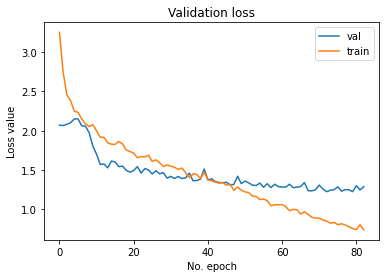

In [6]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Validation loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper right')
plt.show()

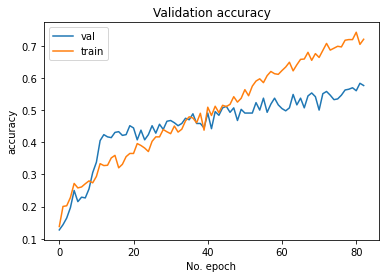

In [7]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

In [8]:
pred_test = best_model.predict(X_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_cnn)

In [9]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           1       0.40      0.26      0.32        38
           2       0.72      0.54      0.62        90
           3       0.60      0.55      0.57        60
           4       0.47      0.61      0.53        44
           5       0.52      0.88      0.65        33
           6       0.65      0.71      0.68        42
           7       0.61      0.51      0.55        75
           8       0.58      0.72      0.64        50

    accuracy                           0.58       432
   macro avg       0.57      0.60      0.57       432
weighted avg       0.59      0.58      0.58       432



## Making new predictions

In [11]:
model = keras.models.load_model("models/ser_175")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 175, 256)          1536      
                                                                 
 activation (Activation)     (None, 175, 256)          0         
                                                                 
 batch_normalization (BatchN  (None, 175, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 256)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 43, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 128)           1

In [13]:
dummy_feature_input = [list(X_train.loc[0]), list(X_train.loc[1])]  # output format of previous model
model_input = np.expand_dims(dummy_feature_input, axis=2)
model_input

array([[[5.13879661e-01],
        [4.20216500e-01],
        [3.52318310e-01],
        [3.52128765e-01],
        [4.10555228e-01],
        [2.49298959e-01],
        [3.32038850e-01],
        [5.28832254e-01],
        [2.44089480e-01],
        [4.41323976e-01],
        [4.70069313e-01],
        [2.66829587e-01],
        [2.49618022e-01],
        [3.96854861e-01],
        [3.60917658e-01],
        [3.31655576e-01],
        [4.19279684e-01],
        [3.45033404e-01],
        [3.15891851e-01],
        [2.19326411e-01],
        [2.56897994e-01],
        [3.65789160e-01],
        [2.04769100e-01],
        [2.89265888e-01],
        [4.10228502e-01],
        [1.16020585e-01],
        [7.23640742e-01],
        [4.70699569e-01],
        [5.69370298e-01],
        [5.80902369e-01],
        [4.85528610e-01],
        [3.90744057e-01],
        [1.79684575e-01],
        [4.91847265e-01],
        [4.93649178e-01],
        [7.67192377e-01],
        [4.03262273e-01],
        [6.15605219e-01],
        [1.4

In [15]:
preds = model.predict(model_input)
pred_emotions = []
emotion_dict = {1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}
for probs in preds:
    pred = np.argmax(probs)
    pred_emotions.append(pred+1)
print(pred_emotions)
print([emotion_dict[p] for p in pred_emotions])

[6, 4]
['fearful', 'sad']
